In [27]:
%load_ext autoreload
%autoreload 2

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torchaudio

from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build dataset

In [2]:
# For default dataset, set `url="train-clean-100"`
dataset = torchaudio.datasets.LIBRISPEECH("./data", url="dev-clean", download=True)

datum = next(iter(dataset))
sr = datum[1]

num_samples = get_num_samples_for_num_frames(num_frames=129)

audio_in = [audio[0].numpy() for audio in dataset]
audio_in = get_segments_above_threshold(audio_in, num_samples=num_samples, threshold_db=-30)
dataset = tf.convert_to_tensor(audio_in)
dataset = apply_stft(dataset)

/Users/maxhenry/Documents/McGill/COMP588/crf-phase-reconstruction/helpers.py:60: RuntimeWarning: divide by zero encountered in log10
  level_db = 20 * np.log10(rms)
2023-05-07 10:45:39.557874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-07 10:45:39.558004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



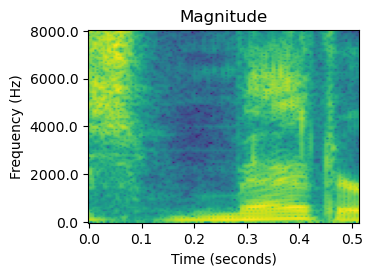

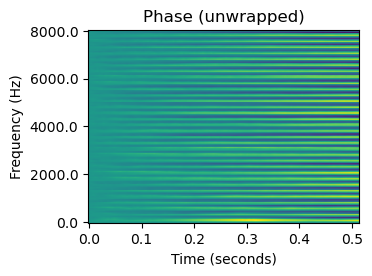

In [3]:
dpi=300

# Plot example.
datum = dataset[15, ...]

plt.figure(figsize=(3.5, 2.5))
plot_stft(tf.math.log(tf.abs(datum)))
plt.title("Magnitude")

plt.savefig("fig/example_magnitude.png", dpi=dpi, bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(3.5, 2.5))
plot_stft(np.unwrap(tf.math.angle(datum), axis=0))
plt.title("Phase (unwrapped)")

plt.savefig("fig/example_phase.png", dpi=dpi, bbox_inches = 'tight')
plt.show()

In [28]:
# Demonstrate reconstructing signal from phase and magnitude components.

X = tf.abs(dataset)
Y = tf.math.angle(dataset)

# Synthesize (a bad) prediction.
Y_hat = tf.random.normal(shape=Y.shape)

y = apply_istft(complex_from_polar(X, Y))
y_hat = apply_istft(complex_from_polar(X, Y_hat))

perfect_score = reconstruction_snr(y, audio_in).mean()
random_score = reconstruction_snr(y, y_hat).mean()

print(f"Perfect reconstruction: {perfect_score}dB")
print(f"Random reconstruction: {random_score}dB")

Perfect reconstruction: 20.66411781311035dB
Random reconstruction: -0.6852326989173889dB


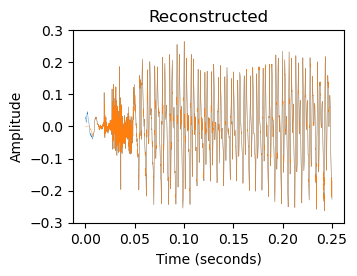

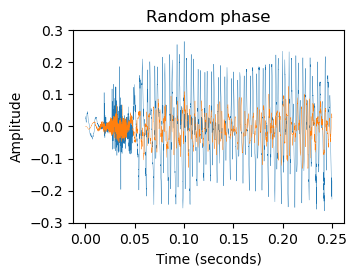

Example SDRs
Perfect:	[28.357218]
Random:		[-0.7442583]


In [52]:
plt.figure(figsize=(3.5, 2.5))
plot_signal(audio_in[1][:4000], sr)
plot_signal(y[1][:4000], sr)
plt.title("Reconstructed")
plt.ylim([-.3, .3])

plt.savefig("fig/example_perfect_reconstruction.png", dpi=dpi, bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(3.5, 2.5))
plot_signal(audio_in[1][:4000], sr)
plot_signal(y_hat[1][:4000], sr)
plt.ylim([-.3, .3])
plt.title("Random phase")

plt.savefig("fig/example_random_phase.png", dpi=dpi, bbox_inches = 'tight')
plt.show()

best = reconstruction_snr(tf.expand_dims(audio_in[1][:4000], 0), tf.expand_dims(y[1][:4000], 0))
worst = reconstruction_snr(tf.expand_dims(audio_in[1][:4000], 0), tf.expand_dims(y_hat[1][:4000], 0))

print(f"Example SDRs\nPerfect:\t{best}\nRandom:\t\t{worst}")